# Surname Classification with BiDirectional RNNs

## Dataset Info

The surnames dataset has been collected from a couple different sources. 

#### Value Counts for the Nationality:

```
russian       9408
english       3668
arabic        2000
japanese       991
german         724
italian        709
czech          519
spanish        298
dutch          297
french         277
chinese        268
irish          232
greek          203
polish         139
scottish       100
korean          94
portuguese      74
vietnamese      73
Name: nationality, dtype: int64
```

## Model Info

The `CharBiRNN` uses a BiDirectional RNN to get a feature vector for each character in each surname. These feature vectors are averaged. Then, the average feature vector is classified to its nationality.

In [1]:
from argparse import Namespace
from collections import Counter
import json
import os
os.environ['OMP_NUM_THREADS'] = '4' 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

from vocabulary import Vocabulary

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 6)

START_TOKEN = "^"
END_TOKEN = "_"

# Dataset

### Dataset Utilities

In [2]:
def count_tokens(x_data_list):
    """Count the tokens in the data list
    
    Args:
        x_data_list (list(list(str))): a list of lists, each sublist is a list of string tokens. 
            In other words, a list of the data points where the data points have been tokenized.
    Returns:
        dict: a mapping from tokens to their counts 
    
    """
    # alternatively
    # return Counter([token for x_data in x_data_list for token in x_data])
    counter = Counter()
    for x_data in x_data_list:
        for token in x_data:
            counter[token] += 1
    return counter

def add_splits(df, target_y_column, split_proportions=(0.7, 0.15, 0.15), seed=0):
    """Add 'train', 'val', and 'test' splits to the dataset
    
    Args:
        df (pd.DataFrame): the data frame to assign splits to
        target_y_column (str): the name of the label column; in order to
            preserve the class distribution between splits, the label column
            is used to group the datapoints and splits are assigned within these groups.
        split_proportions (tuple(float, float, float)): three floats which represent the
            proportion in 'train', 'val, 'and 'test'. Must sum to 1. 
        seed (int): the random seed for making the shuffling deterministic. If the dataset and seed
            are kept the same, the split assignment is deterministic. 
    Returns:
        pd.DataFrame: the input dataframe with a new column for split assignments; note: row order
            will have changed.
            
    """
    df_by_label = {label: [] for label in df[target_y_column].unique()}
    for _, row in df.iterrows():
        df_by_label[row[target_y_column]].append(row.to_dict())
    
    np.random.seed(seed)
    
    assert sum(split_proportions) == 1, "`split_proportions` should sum to 1"
    train_p, val_p, test_p = split_proportions
    
    out_df = []
    # to ensure consistent behavior, lexicographically sort the dictionary
    for _, data_points in sorted(df_by_label.items()):
        np.random.shuffle(data_points)
        n_total = len(data_points)
        n_train = int(train_p * n_total)
        n_val = int(val_p * n_total)
        
        for data_point in data_points[:n_train]:
            data_point['split'] = 'train'
            
        for data_point in data_points[n_train:n_train+n_val]:
            data_point['split'] = 'val'
            
        for data_point in data_points[n_train+n_val:]:
            data_point['split'] = 'test'
        
        out_df.extend(data_points)
    
    return pd.DataFrame(out_df)


### Supervised Text Vectorizer

In [3]:
class SupervisedTextVectorizer:
    """A composite data structure that uses Vocabularies to map text and its labels to integers
    
    Attributes:
        token_vocab (Vocabulary): the vocabulary managing the mapping between text tokens and 
            the unique indices that represent them
        label_vocab (Vocabulary): the vocabulary managing the mapping between labels and the
            unique indices that represent them.
        max_seq_length (int): the length of the longest sequence (including start or end tokens
            that will be prepended or appended).
    """
    def __init__(self, token_vocab, label_vocab, max_seq_length):
        """Initialize the SupervisedTextVectorizer
        
        Args:
            token_vocab (Vocabulary): the vocabulary managing the mapping between text tokens and 
                the unique indices that represent them
            label_voab (Vocabulary): the vocabulary managing the mapping between labels and the
                unique indices that represent them.
            max_seq_length (int): the length of the longest sequence (including start or end tokens
                that will be prepended or appended).
        """
        self.token_vocab = token_vocab
        self.label_vocab = label_vocab
        self.max_seq_length = max_seq_length
        
    def _wrap_with_start_end(self, x_data):
        """Prepend the start token and append the end token.
        
        Args:
            x_data (list(str)): the list of string tokens in the data point
        Returns:
            list(str): the list of string tokens with start token prepended and end token appended
        """
        return [self.token_vocab.start_token] + x_data + [self.token_vocab.end_token]
    
    def vectorize(self, x_data, y_label):
        """Convert the data point and its label into their integer form
        
        Args:
            x_data (list(str)): the list of string tokens in the data point
            y_label (str,int): the label associated with the data point
        Returns:
            numpy.ndarray, int: x_data in vector form, padded to the max_seq_length; and 
                the label mapped to the integer that represents it
        """
        x_data = self._wrap_with_start_end(x_data)
        x_vector = np.zeros(self.max_seq_length).astype(np.int64)
        x_data_indices = [self.token_vocab[token] for token in x_data]
        x_vector[:len(x_data_indices)] = x_data_indices
        y_index = self.label_vocab[y_label]
        return x_vector, y_index
    
    def transform(self, x_data_list, y_label_list):
        """Transform a dataset by vectorizing each datapoint
        
        Args: 
            x_data_list (list(list(str))): a list of lists, each sublist contains string tokens
            y_label_list (list(str,int)): a list of either strings or integers. the y label can come
                as strings or integers, but they are remapped with the label_vocab to a unique integer
        Returns:
            np.ndarray(matrix), np.ndarray(vector): the vectorized x (matrix) and vectorized y (vector) 
        """
        x_matrix = []
        y_vector = []
        for x_data, y_label in zip(x_data_list, y_label_list):
            x_vector, y_index = self.vectorize(x_data, y_label)
            x_matrix.append(x_vector)
            y_vector.append(y_index)
        
        return np.stack(x_matrix), np.stack(y_vector)
    
    @classmethod
    def from_df(cls, df, target_x_column, target_y_column, token_count_cutoff=0):
        """Instantiate the SupervisedTextVectorizer from a standardized dataframe
        
        Standardized DataFrame has a special meaning:
            there is a column that has been tokenized into a list of strings
        
        Args:
            df (pd.DataFrame): the dataset with a tokenized text column and a label column
            target_x_column (str): the name of the tokenized text column
            target_y_column (str): the name of the label column
            token_count_cutoff (int): [default=0] the minimum token frequency to add to the
                token_vocab.  Any tokens that are less frequent will not be added.
        Returns:
            SupervisedTextVectorizer: the instantiated vectorizer
        """
        # get the x data (the observations)
        target_x_list = df[target_x_column].tolist()
        # compute max sequence length, add 2 for the start, end tokens
        max_seq_length = max(map(len, target_x_list)) + 2 
        
        # populate token vocab        
        token_vocab = Vocabulary(use_unks=False,
                                 use_mask=True,
                                 use_start_end=True,
                                 start_token=START_TOKEN,
                                 end_token=END_TOKEN)
        counts = count_tokens(target_x_list)
        # sort counts in reverse order
        for token, count in sorted(counts.items(), key=lambda x: x[1], reverse=True):
            if count < token_count_cutoff:
                break
            token_vocab.add(token)

        # populate label vocab
        label_vocab = Vocabulary(use_unks=False, use_start_end=False, use_mask=False)
        # add the sorted unique labels 
        label_vocab.add_many(sorted(df[target_y_column].unique()))
        
        return cls(token_vocab, label_vocab, max_seq_length)
    
    def save(self, filename):
        """Save the vectorizer using json to the file specified
        
        Args:
            filename (str): the output file
        """
        vec_dict = {"token_vocab": self.token_vocab.get_serializable_contents(),
                    "label_vocab": self.label_vocab.get_serializable_contents(),
                    'max_seq_length': self.max_seq_length}

        with open(filename, "wb") as fp:
            json.dump(vec_dict, fp)
        
    @classmethod
    def load(cls, filename):
        """Load the vectorizer from the json file it was saved to
        
        Args:
            filename (str): the file into which the vectorizer was saved.
        Returns:
            SupervisedTextVectorizer: the instantiated vectorizer
        """
        with open(filename, "rb") as fp:
            contents = json.load(fp)

        contents["token_vocab"] = Vocabulary.deserialize_from_contents(contents["token_vocab"])
        contents["label_vocab"] = Vocabulary.deserialize_from_contents(contents["label_vocab"])
        return cls(**contents)

### Supervised Text Dataset

In [4]:
class SupervisedTextDataset(Dataset):
    """
    Attributes:
        vectorizer (SupervisedTextVectorizer): an instantiated vectorizer
        active_split (str): the string name of the active split
        
        # internal use
        _split_df (dict): a mapping from split name to partitioned DataFrame
        _vectorized (dict): a mapping from split to an x data matrix and y vector
        _active_df (pd.DataFrame): the DataFrame corresponding to the split
        _active_x (np.ndarray): a matrix of the vectorized text data
        _active_y (np.ndarray): a vector of the vectorized labels
    """
    def __init__(self, df, vectorizer, target_x_column, target_y_column):
        """Initialize the SupervisedTextDataset
        
        Args:
            df (pd.DataFrame): the dataset with a text and label column
            vectorizer (SupervisedTextVectorizer): an instantiated vectorizer
            target_x_column (str): the column containing the tokenized text
            target_y_column (str): the column containing the label
        """
        self._split_df = {
            'train': df[df.split=='train'],
            'val': df[df.split=='val'],
            'test': df[df.split=='test']
        }
        
        self._vectorized = {}
        for split_name, split_df in self._split_df.items():
            self._vectorized[split_name] = \
                vectorizer.transform(x_data_list=split_df[target_x_column].tolist(), 
                                     y_label_list=split_df[target_y_column].tolist())
        self.vectorizer = vectorizer
        self.active_split = None
        self._active_df = None
        self._active_x = None
        self._active_y = None
        
        self.set_split("train")
        
    def set_split(self, split_name):
        """Set the active split
        
        Args:
            split_name (str): the name of the split to make active; should
                be one of 'train', 'val', or 'test'
        """
        self.active_split = split_name
        self._active_x, self._active_y = self._vectorized[split_name]
        self._active_df = self._split_df[split_name]
    
    def __getitem__(self, index):
        """Return the data point corresponding to the index
        
        Args:
            index (int): an int between 0 and len(self._active_x)
        Returns:
            dict: the data for this data point. Has the following form:
                {"x_data": the vectorized text data point, 
                 "y_target": the index of the label for this data point, 
                 "x_lengths": method: the number of nonzeros in the vector,
                 "data_index": the provided index for bookkeeping}
        """
        return {
            "x_data": self._active_x[index],
            "y_target": self._active_y[index],
            "x_lengths": len(self._active_x[index].nonzero()[0]),
            "data_index": index
        }
    
    def __len__(self):
        """The length of the active dataset
        
        Returns:
            int: len(self._active_x)
        """
        return self._active_x.shape[0]

### Dataset Loading Function

In [5]:
def character_tokenizer(input_string):
    """Tokenized a string a list of its characters
    
    Args:
        input_string (str): the character string to tokenize
    Returns:
        list: a list of characters
    """
    return list(input_string.lower())

def load_surname_dataset(dataset_csv, tokenizer_func, saved_vectorizer_file=None):
    """Load the surname dataset 
    
    Args:
        dataset_csv (str): the location of the dataset
        tokenizer_func (function): the tokenizing function to turn each datapoint into 
            its tokenized form
        saved_vectorizer_file (str or None): [default=None] if not None, load the vectorizer
            from the file
    """
    df = add_splits(pd.read_csv(dataset_csv), 'nationality')
    df['tokenized'] = df.surname.apply(tokenizer_func)
    if saved_vectorizer_file is not None:
        vectorizer = SupervisedTextVectorizer.load(saved_vectorizer_file)
    else:
        vectorizer = SupervisedTextVectorizer.from_df(df, 
                                                      target_x_column='tokenized', 
                                                      target_y_column='nationality')
    dataset = SupervisedTextDataset(df=df, 
                                    vectorizer=vectorizer, 
                                    target_x_column='tokenized', 
                                    target_y_column='nationality')
    
    return dataset

### Verify it loads

In [6]:
dataset = load_surname_dataset("../data/surnames.csv", 
                               character_tokenizer,
                               "../modelzoo/surnames.vectorizer")
dataset[0]

{'x_data': array([ 1,  9, 12, 13, 19,  7,  8,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0]), 'y_target': 0, 'x_lengths': 8, 'data_index': 0}

# Model

### Model Utilities

In [7]:
def new_parameter(*size):
    """Initialize a new parameter
    
    Args:
        size (*args): being star args, pass in any number of ints to create a 
            parameter tensor of that size.
    Returns:
        nn.Parameter: a Tensor that has some extra bookkeeping
    """
    out = torch.randn(*size, requires_grad=True, dtype=torch.float32)
    torch.nn.init.xavier_normal_(out)
    return nn.Parameter(out)

def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)

### Model Definitions

#### CharBiRNN

In [8]:
class CharBiRNN(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_classes, hidden_size, dropout_p=0.5):
        """Initialize the CharRNN
        
        Args:
            embedding_size (int): size of each embedding vector
            num_embeddings (int): number of input characters
            num_classes (int): number of characters to predict to
            hidden_size (int): the intermediate representation size
        """
        super(CharBiRNN, self).__init__()
        
        self.emb = nn.Embedding(embedding_dim=embedding_size, 
                                num_embeddings=num_embeddings, 
                                padding_idx=0)
        
        self.rnn = nn.GRU(input_size=embedding_size, 
                          hidden_size=hidden_size, 
                          batch_first=True,
                          bidirectional=True)

        self.fc1 = nn.Linear(in_features=hidden_size * 2, 
                            out_features=hidden_size * 2)
        
        self.fc2 = nn.Linear(in_features=hidden_size * 2, 
                             out_features=num_classes)
        
        self.dropout_p = dropout_p
    
    
    def forward(self, x_in, x_lengths, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            x_lengths
            apply_softmax (bool): a flag for the softmax activation should 
                be false if used with the Cross Entropy losses. See note below.
        Returns:
            torch.FloatTensor: [shape=(batch_size, num_classes)]
                The vector for each data point in the batch is 
                    if `apply_softmax=False`, the pre-softmax prediction vector
                    else, the softmax'ed prediction vector
        Note:
            It is useful to not softmax the prediction vector because there is
            a corresponding loss function optimized for it.  In essence, the loss
            function associated with optimizing probabilities of multinomials is called
            Negative Log Likelihood (NLL). To apply NLL, you first apply the log function.
            This function cancels out with the exponential function of the softmax
            and so some simplification can occur to shortcut the extra computations. 
                    
        """
        # x_in.shape == (batch_size, seq_size)
        
        x_embedded = self.emb(x_in)
        # x_embedded.shape == (batch, seq_size, embedding_size)
        lengths = x_lengths.detach().cpu().numpy()
        x_packed_prernn = torch.nn.utils.rnn.pack_padded_sequence(x_embedded, 
                                                                  lengths=lengths,
                                                                  batch_first=True,
                                                                  enforce_sorted=False)
        
        x_packed_postrnn, _ = self.rnn(x_packed_prernn)
        x_post_rnn, _ = torch.nn.utils.rnn.pad_packed_sequence(x_packed_postrnn, 
                                                               batch_first=True)
        # x_post_rnn.shape == (batch_size, seq_size, 2 * hidden_size)
        x_post_rnn = x_post_rnn.sum(dim=1) / x_lengths.unsqueeze(dim=1).float()

        y_out = F.elu(self.fc1(x_post_rnn))
        y_out = self.fc2(F.dropout(y_out, p=self.dropout_p))
        

        if apply_softmax:
            y_out = F.softmax(y_out)
            
        return y_out

### Prototyping

In [9]:
batch = next(iter(DataLoader(dataset, batch_size=8)))
model = CharBiRNN(embedding_size=8, 
               num_embeddings=len(dataset.vectorizer.token_vocab), 
               num_classes=len(dataset.vectorizer.label_vocab),
               hidden_size=8)
model(batch['x_data'], batch['x_lengths']).shape

torch.Size([8, 18])

# Training

### Training Utilities

In [10]:
def compute_accuracy(y_pred, y_true):
    """Compute the accuracy between a matrix of predictions and a vector of label indices
    
    Args:
        y_pred (torch.FloatTensor): [shape=(batch_size, num_classes)]
            The matrix of predictions
        y_true (torch.FloatTensor): [shape=(batch_size,)]
            The vector of label indices
    """
    y_pred_indices = y_pred.argmax(dim=1)
    n_correct = torch.eq(y_pred_indices, y_true).sum().item()
    return n_correct / len(y_pred_indices) * 100


def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu", dataloader_kwargs=None): 
    """Generate batches from a dataset
    
    Args:
        dataset (torch.utils.data.Dataset): the instantiated dataset
        batch_size (int): the size of the batches
        shuffle (bool): [default=True] batches are formed from shuffled indices
        drop_last (bool): [default=True] don't return the final batch if it's smaller
            than the specified batch size
        device (str): [default="cpu"] the device to move the tensors to
        dataloader_kwargs (dict or None): [default=None] Any additional arguments to the
            DataLoader can be specified
    Yields:
        dict: a dictionary mapping from tensor name to tensor object where the first
            dimension of tensor object is the batch dimension
    Note: 
        This function is mostly an iterator for the DataLoader, but has the added
        feature that it moves the tensors to a target device. 
    """
    dataloader_kwargs = dataloader_kwargs or {}
    
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last, **dataloader_kwargs)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

        
class TrainState:
    """A data structure for managing training state operations.
    
    The TrainState will monitor validation loss and everytime a new best loss
        (lower is better) is observed, a couple things happen:
        
        1. The model is checkpointed
        2. Patience is reset
    
    Attributes:
        model (torch.nn.Module): the model being trained and will be
            checkpointed during training.
        dataset (SupervisedTextDataset, TextSequenceDataset): the dataset 
            which is being iterate during training; must have the `active_split`
            attribute. 
        log_dir (str): the directory to output the checkpointed model 
        patience (int): the number of epochs since a new best loss was observed
        
        # Internal Use
        _full_model_path (str): `log_dir/model_state_file`
        _split (str): the active split
        _best_loss (float): the best observed loss
    """
    def __init__(self, model, dataset, log_dir, model_state_file="model.pth"):
        """Initialize the TrainState
        
        Args:
            model (torch.nn.Module): the model to be checkpointed during training
            dataset (SupervisedTextDataset, TextSequenceDataset): the dataset 
                which is being iterate during training; must have the `active_split`
                attribute. 
            log_dir (str): the directory to output the checkpointed model 
            model_state_file (str): the name of the checkpoint model
        """
        self.model = model
        self.dataset = dataset
        self._full_model_path = os.path.join(log_dir, model_state_file)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        self.log_dir = log_dir
        
        self._metrics_by_split = {
            'train': {}, 
            'val': {}, 
            'test': {}
        }
        
        self._split = 'train'
        self._best_loss = 10**10
        self.patience = 0
        
    def _init_metric(self, split, metric_name):
        """Initialize a metric to the specified split
        
        A dictionary is created in `self._metrics_by_split` with
            the keys 'running', 'count', and 'history'. 
        
        Args:
            split (str): the target split to record the metric
            metric_name (str): the name of the metric
        """
        self._metrics_by_split[split][metric_name] = {
            'running': 0.,
            'count': 0,
            'history': []
        }
        
    def _update_metric(self, metric_name, metric_value):
        """Update a metric with an observed value
        
        Specifically, the running average is updated.
        
        Args:
            metric_name (str): the name of the metric
            metric_value (float): the observed value of the metric
        """
        if metric_name not in self._metrics_by_split[self._split]:
            self._init_metric(self._split, metric_name)
        metric = self._metrics_by_split[self._split][metric_name]
        metric['count'] += 1
        metric['running'] += (metric_value - metric['running']) / metric['count']
        
    def set_split(self, split):
        """Set the dataset split
        
        Args:
            split (str): the target split to set
        """
        self._split = split
        
    def get_history(self, split, metric_name):
        """Get the history of values for any metric in any split
        
        Args:
            split (str): the target split
            metric_name (str): the target metric
            
        Returns:
            list(float): the running average of each epoch for `metric_name` in `split` 
        """
        return self._metrics_by_split[split][metric_name]['history']
    
    def get_value_of(self, split, metric_name):
        """Retrieve the running average of any metric in any split
        
        Args:
            split (str): the target split
            metric_name (str): the target metric
            
        Returns:
            float: the running average for `metric_name` in `split`
        """
        return self._metrics_by_split[split][metric_name]['running']
        
    def log_metrics(self, **metrics):
        """Log some values for some metrics
        
        Args:
            metrics (kwargs): pass keyword args with the form `metric_name=metric_value`
                to log the metric values into the attribute `_metrics_by_split`.
        """
        self._split = self.dataset.active_split
        for metric_name, metric_value in metrics.items():
            self._update_metric(metric_name, metric_value)
            
    def log_epoch_end(self):
        """Log the end of the epoch. 
        
        Some key functions happen at the end of the epoch:
            - for each metric in each split running averages, counts, 
              and history are updated
            - the model is checkpointed if a new best value is observed
            - patience is incremented if a new best value is not observed
        """
        for split_dict in self._metrics_by_split.values():
            for metric_dict in split_dict.values():
                metric_dict['history'].append(metric_dict['running'])
                metric_dict['running'] = 0.0
                metric_dict['count'] = 0
                
        if 'loss' in self._metrics_by_split['val']:
            val_loss = self._metrics_by_split['val']['loss']['history'][-1]
            if val_loss < self._best_loss:
                self._best_loss = val_loss
                self.save_model()
                self.patience = 0
            else:
                self.patience += 1
    
    def save_model(self):
        """ Save `model` to `log_dir/model_state_file` """
        torch.save(self.model.state_dict(), self._full_model_path)
    
    def reload_best(self):
        """ reload `log_dir/model_state_file` to `model` """
        if os.path.exists(self._full_model_path):
            self.model.load_state_dict(torch.load(self._full_model_path))

### Args

In [13]:
args = Namespace(
    # dataset
    surname_csv="../data/surnames.csv",
    # model hyper parameters
    embedding_size=100,
    hidden_size=100,
    num_embeddings=-1,
    num_classes=-1,
    # training options
    batch_size=64,
    cuda=False,
    learning_rate=0.001,
    num_epochs=100,
    patience_threshold=3,
)


# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")
args.device

Using CUDA: False


device(type='cpu')

### Bonus: RAdam, a State-of-the-Art Optimizer

In [14]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


### Instantiation

In [18]:

dataset = load_surname_dataset(args.surname_csv, 
                               tokenizer_func=character_tokenizer)

args.num_embeddings = len(dataset.vectorizer.token_vocab)
args.num_classes = len(dataset.vectorizer.label_vocab)

model = CharBiRNN(embedding_size=args.embedding_size, 
               hidden_size=args.hidden_size,
               num_embeddings=args.num_embeddings,
               num_classes=args.num_classes)    

# reference: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/utils/class_weight.py#L54    
class_counts = dataset._split_df['train'].nationality.value_counts().to_dict()
total_count = sum(class_counts.values())
sorted_counts = sorted(class_counts.items(), 
                       key=lambda item: dataset.vectorizer.label_vocab[item[0]])
class_weights = total_count / torch.tensor([len(sorted_counts) * count for _, count in sorted_counts], dtype=torch.float32)

### Training Routine

In [19]:
model = model.to(args.device)

train_state = TrainState(model=model, dataset=dataset, log_dir='./logs/charrnn_classify_surnames',  
                         model_state_file='model.pth')

optimizer = RAdam(model.parameters(), lr=args.learning_rate, weight_decay=0.0001)

# loss function with class-weighted modifications
loss_func = nn.CrossEntropyLoss(weight=class_weights)


# progress bars
epoch_bar = tqdm_notebook(desc='epochs', total=args.num_epochs, position=1)

dataset.set_split("train")
train_bar = tqdm_notebook(desc='training', total=len(dataset)//args.batch_size)

dataset.set_split("val")
val_bar = tqdm_notebook(desc='validation', total=len(dataset)//args.batch_size)
        

try:
    for _ in range(args.num_epochs):
        model.train()
        dataset.set_split("train")
        
        for batch in generate_batches(dataset, batch_size=args.batch_size, device=args.device):
            # Step 1: clear the gradients 
            optimizer.zero_grad()
            
            # Step 2: compute the outputs
            y_prediction = model(batch['x_data'], batch['x_lengths'])

            # Step 3: compute the loss
            loss = loss_func(y_prediction, batch['y_target'])
            
            # Step 4: propagate the gradients
            loss.backward() 
            
            # Step 5: update the model weights
            optimizer.step()
            
            # Auxillary: logging
            train_state.log_metrics(loss=loss.item(), 
                                    accuracy=compute_accuracy(y_prediction, batch['y_target']))
            
            train_bar.set_postfix(loss=train_state.get_value_of(split="train", metric_name="loss"),
                                  acc=train_state.get_value_of(split="train", metric_name="accuracy"))
            train_bar.update()
            
        # loop over test dataset
        
        model.eval()
        dataset.set_split("val")
        
        for batch in generate_batches(dataset, batch_size=args.batch_size, device=args.device):
            # Step 1: compute the outputs
            y_prediction = model(batch['x_data'], batch['x_lengths'])

            # Step 2: compute the loss
            loss = loss_func(y_prediction, batch['y_target'])
            
            # Auxillary: logging
            train_state.log_metrics(loss=loss.item(), 
                                    accuracy=compute_accuracy(y_prediction, batch['y_target']))
            
            val_bar.set_postfix(loss=train_state.get_value_of(split="val", metric_name="loss"),
                                  acc=train_state.get_value_of(split="val", metric_name="accuracy"))
            val_bar.update()

        
        epoch_bar.set_postfix(train_loss=train_state.get_value_of(split="train", 
                                                                  metric_name="loss"), 
                              train_accuracy=train_state.get_value_of(split="train", 
                                                                      metric_name="accuracy"),
                              val_loss=train_state.get_value_of(split="val", 
                                                                metric_name="loss"), 
                              val_accuracy=train_state.get_value_of(split="val", 
                                                                    metric_name="accuracy"),
                              patience=train_state.patience)
        epoch_bar.update()
        train_state.log_epoch_end()
        train_bar.n = 0
        val_bar.n = 0
        
        if train_state.patience > args.patience_threshold:
            break
            
    train_state.reload_best()
    model.eval()
    dataset.set_split("test")
    test_bar = tqdm_notebook(desc='test', total=len(dataset)//args.batch_size)

    for batch in generate_batches(dataset, batch_size=args.batch_size, device=args.device):
        # Step 1: compute the outputs
        y_prediction = model(batch['x_data'], batch['x_lengths'])

        # Step 2: compute the loss
        loss = loss_func(y_prediction, batch['y_target'])

        # Auxillary: logging
        train_state.log_metrics(loss=loss.item(), 
                                accuracy=compute_accuracy(y_prediction, batch['y_target']))

        test_bar.set_postfix(loss=train_state.get_value_of(split="test", metric_name="loss"),
                             acc=train_state.get_value_of(split="test", metric_name="accuracy"))
        test_bar.update()
    

except KeyboardInterrupt:
    print("...")

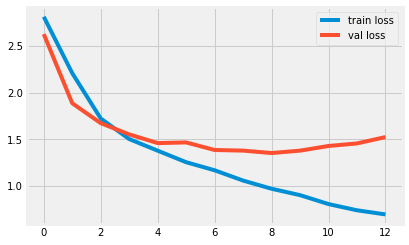

In [20]:
train_loss_history = train_state.get_history(split='train', metric_name='loss')
val_loss_history = train_state.get_history(split='val', metric_name='loss')
plt.plot(train_loss_history, label='train loss')
plt.plot(val_loss_history, label='val loss')
plt.legend()

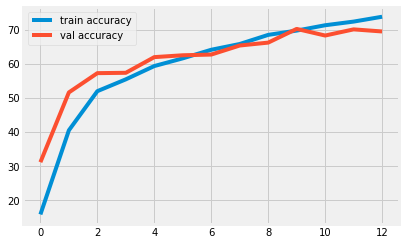

In [21]:
train_accuracy_history = train_state.get_history(split='train', metric_name='accuracy')
val_accuracy_history = train_state.get_history(split='val', metric_name='accuracy')
plt.plot(train_accuracy_history, label='train accuracy')
plt.plot(val_accuracy_history, label='val accuracy')
plt.legend()


In [22]:
def vectorize_surname(surname):
    # surname is lowercased here to match the training data
    surname_indices = list(dataset.vectorizer.token_vocab.map(surname.lower(), include_start_end=True))
    surname_vector = torch.tensor(surname_indices, dtype=torch.int64).unsqueeze(dim=0)
    surname_length = torch.tensor([len(surname_indices)], dtype=torch.int64)
    return surname_vector, surname_length
    
def predict_nationality(model, surname):
    model = model.to("cpu")
    surname_vector, surname_length = vectorize_surname(surname)
    y_prediction = model(surname_vector, surname_length)
    _, nationality_index = y_prediction.max(dim=1)
    return dataset.vectorizer.label_vocab.lookup(nationality_index.item())

In [23]:
model = model.eval()

In [24]:
predict_nationality(model, 'satoshi nakamoto')

'japanese'

In [25]:
predict_nationality(model, 'McMahan')

'irish'

In [26]:
predict_nationality(model, 'Bismarck')

'german'

In [27]:
predict_nationality(model, 'Anderson')

'english'